In [1]:
import numpy as np
import control.matlab as ctrl
import sympy
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

In [2]:
m = sympy.Symbol("m")
k = sympy.Symbol("k")
A = sympy.Matrix([[0, 1], [-k/m, 0]])
B = sympy.Matrix([[0], [1/m]])

In [3]:
display(A,B)

Matrix([
[   0, 1],
[-k/m, 0]])

Matrix([
[  0],
[1/m]])

In [15]:
M = 1
K = 10
A_true = sympy.matrix2numpy(A.subs(m, M).subs(k, K)).astype(float)
B_true = sympy.matrix2numpy(B.subs(m, M)).astype(float)
C = np.eye(len(A_true))
sys = ctrl.ss(A_true, B_true, C, 0)

In [16]:
Td = np.arange(0, 10, 0.01) #シミュレーション時間0~1s,0.01s刻み

X0 = [1.,0.] # 初期状態量
y, tt = ctrl.initial(sys, Td, X0) #線形システムシミュレータ

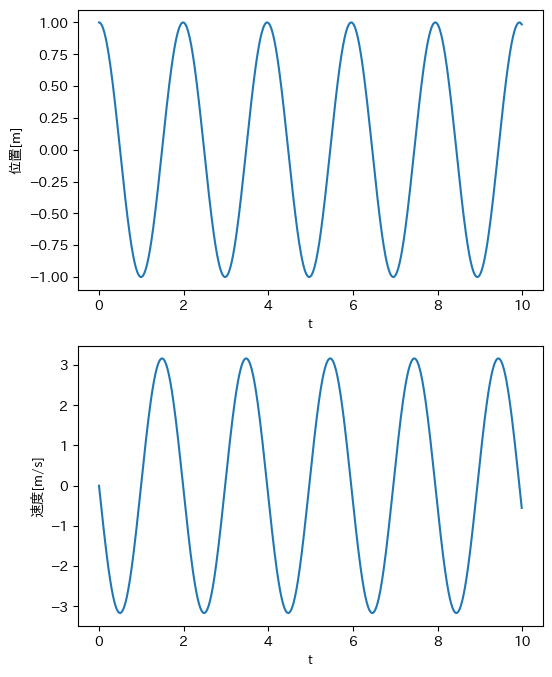

In [17]:
df = pd.concat((pd.DataFrame(tt),pd.DataFrame(y)), axis = 1)
df.columns = ["t", "pos", "vel"]

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel("位置[m]")
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_ylabel("速度[m/s]")

df.plot(ax = ax1, x = "t", y = "pos", legend=False)
df.plot(ax = ax2, x = "t", y = "vel", legend=False)

plt.show()

In [18]:
# 設計パラメータ
Q = np.diag([10,1])
R = 1

In [19]:
A_m1 = sys.A
B_m1 = sys.B
F1, X1, E1 = ctrl.lqr(A_m1, B_m1, Q, R) #リカッチ方程式を解く

In [20]:
#固有値の確認
print("元々の固有値")
display(np.linalg.eigvals(sys.A))
print("状態フィードバック系の固有値")
# display(np.linalg.eigvals(A-np.dot(B,F)))
display(E1)

元々の固有値


array([0.+3.16227766j, 0.-3.16227766j])

状態フィードバック系の固有値


array([-0.7028828+3.161336j, -0.7028828-3.161336j], dtype=complex64)

In [21]:
Td = np.arange(0, 10, 0.01) #シミュレーション時間0~1s,0.01s刻み
Ud = 0*(Td>0) #入力信号（ステップ入力）

X0 = [1.0, 0] # 初期状態量
sim_sys = ctrl.ss(sys.A-np.dot(sys.B,F1), sys.B, C, 0)
y, tt, x = ctrl.lsim(sim_sys, Ud, Td, X0) #線形システムシミュレータ

In [22]:
df1 = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F1.T))), axis = 1) #u =-Fx 
df1.columns = ["t", "位置：モデル化誤差なし", "速度：モデル化誤差なし", "input"]

In [23]:
M = 1 * 0.1
K = 10 * 0.1
A_m2 = sympy.matrix2numpy(A.subs(m, M).subs(k, K)).astype(float)
B_m2 = sympy.matrix2numpy(B.subs(m, M)).astype(float)

F2, X2, E2 = ctrl.lqr(A_m2, B_m2, Q, R)

In [24]:
sim_sys = ctrl.ss(sys.A-np.dot(sys.B,F2), sys.B, C, 0)
y, tt, x = ctrl.lsim(sim_sys, Ud, Td, X0) #線形システムシミュレータ

In [25]:
df2 = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F2.T))), axis = 1) #u =-Fx 
df2.columns = ["t", "位置：モデル化誤差あり", "速度：モデル化誤差あり", "input"]

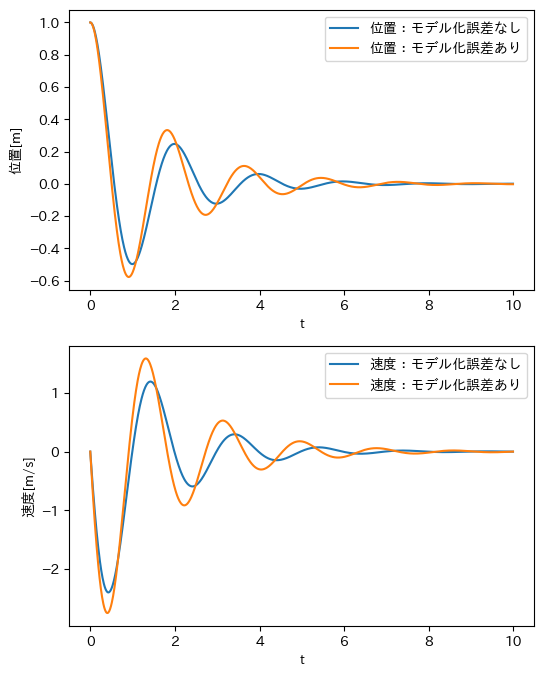

In [26]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel("位置[m]")
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_ylabel("速度[m/s]")

df1.plot(ax = ax1, x = "t", y = "位置：モデル化誤差なし")
df1.plot(ax = ax2, x = "t", y = "速度：モデル化誤差なし")

df2.plot(ax = ax1, x = "t", y = "位置：モデル化誤差あり")
df2.plot(ax = ax2, x = "t", y = "速度：モデル化誤差あり")

plt.show()